# Abstractive Text Summarization

[Post](https://towardsdatascience.com/data-scientists-guide-to-summarization-fc0db952e363) on getting started with `text summarization`, their pros and cons and much more.

**There 3 different training models used here**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**To see the full learning and results of all the 3 model go to the end of the notebook in the `Running all the 3 different models` section**

The `model (the trained model)`, `encoder_model (for inference)` and `decoder_model (for inference)` for **Seq2Seq with just LSTMs** are only saved.

![](https://media.giphy.com/media/dsKnRuALlWsZG/giphy.gif)

In [1]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [2]:
!pip install -q contractions==0.0.48

In [3]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [4]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## 🪂 Getting the data

In [5]:
filename1 = '../input/news-summary/news_summary.csv'
filename2 = '../input/news-summary/news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [6]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
1722,Chhavi Tyagi,"06 Jan 2017,Friday","Modi must go, let Advani, Jaitley or Rajnath l...",http://indiatoday.intoday.in/story/modi-advani...,West Bengal Chief Minister Mamata Banerjee on ...,A belligerent Mamata Banerjee continued her at...
1354,Chhavi Tyagi,"31 Jan 2017,Tuesday",Former Minister E Ahamed collapses in Parliament,http://indiatoday.intoday.in/story/kerala-mp-e...,"E Ahamed, the former MoS for external affairs ...",IUML leader E Ahamed today suffered a heart at...
3951,Tarun Khanna,"04 Apr 2017,Tuesday","Give us EVM for 72 hrs, will show how to rig i...",http://indiatoday.intoday.in/story/election-co...,Delhi CM Arvind Kejriwal has challenged the El...,The Election Commission (EC) has refuted the a...
1961,Vaibhav Gupta,"21 Dec 2016,Wednesday",Note ban has reduced Andhra's revenue by 30%: ...,http://indiatoday.intoday.in/story/note-ban-hi...,Andhra Pradesh Finance Minister Y Ramakrishnud...,"Vijayawada, Dec 21 (PTI) Demonetisation has le..."
465,Radhika Chugh,"27 Jul 2017,Thursday",6 Congress MPs suspended from Lok Sabha,http://www.hindustantimes.com/india-news/six-c...,Lok Sabha Speaker Sumitra Mahajan on Monday su...,The Lok Sabha Speaker suspended six Congress p...


In [7]:
df2.sample(5)

,headlines,text
53041,Selling sex in Bollywood is dead: Filmmaker Vi...,"Filmmaker Vikram Bhatt, who is known for his b..."
61744,Telangana govt declares Urdu as second officia...,Telangana Chief Minister K Chandrashekar Rao o...
4742,Vanakam Puducherry: Rahul says is PM's answer ...,Taking a dig at PM Narendra Modi for allegedly...
34195,Let's not explore political mileage in Ram's n...,"Talking about the Ayodhya dispute, Vishva Hind..."
26730,"Disappointed, not surprised: Cyrus Mistry on N...",Cyrus Mistry has said he was disappointed but ...


In [8]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
45406,Former Huawei engineer 'marries' robot he buil...,"A former Huawei engineer from China has ""marri..."
101543,Aus brand creates Harry Potter-inspired clothi...,Australian fashion label Black Milk has create...
24029,Australia to sell Kesar variety of Indian mang...,Australia will be selling Kesar variety of Ind...
15782,White House hires outside counsel to deal with...,US Vice President Mike Pence has reportedly hi...
44624,"AT&T updates 4G logo with '5G E', criticised f...",US-based telco AT&T received criticism from it...


The `headlines` column will be treated as `summary` for the text.

## 🏂 Data preparation

In [9]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [10]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
22697,"92 witnesses, 100 evidences in mandsaur gangra...",mandsaur police on tuesday filed a 350-page ch...
79342,pm modi meets fishermen affected by cyclone ockhi,prime minister narendra modi on tuesday met fi...
51795,can't eat dal-chawal all day: shreyas on doing...,"shreyas talpade has said, ""one can't eat 'dal-..."
33033,govt restricts operations of 2.09 lakh firms' ...,finance ministry on tuesday said operations of...
51218,suffering from facial paralysis: simran writer...,"apurva asrani, co-writer of kangana ranaut's '..."


In [11]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
69141,"who are the sentinelese, tribe that killed an ...",the sentinelese are an indigenous tribe who ha...
8469,internet should be utility available to whole ...,"chinas e-commerce giant alibabas founder, jack..."
41465,"maoists kill watchman, set ablaze 5 vehicles i...","maoists shot dead a watchman, suspecting him t..."
99162,salmans nephew ahils 1st birthday celebrated i...,salman khans sister arpita khan sharma shared ...
15109,"perhaps rahul plans to win polls in russia, in...","mocking congress vice president rahul gandhi, ..."


In [12]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [13]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [14]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [15]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [16]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
54141,jpmorgan made bn months record us bank,jpmorgan chase biggest us bank made billion pa...
10135,google like cult says engineer fired mthemo,former google engineer james damore fired page...
12851,ban plying atm cash vans pm mha suggests centre,ministry home affairs mha proposed atms replen...
39281,ongc gives inprinciple nod acquire govts stake...,board staterun oil natural gas corporation ong...
75117,pakistan allocates aaa1 crore defence,pakistan finance minister miftah ismail friday...


In [17]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [18]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

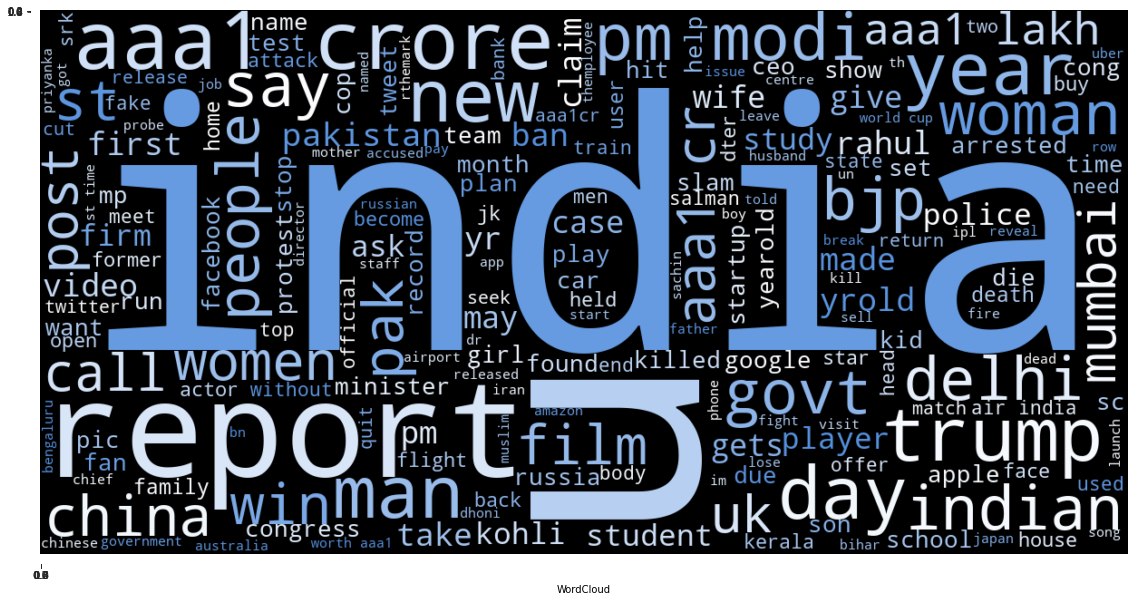

In [19]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

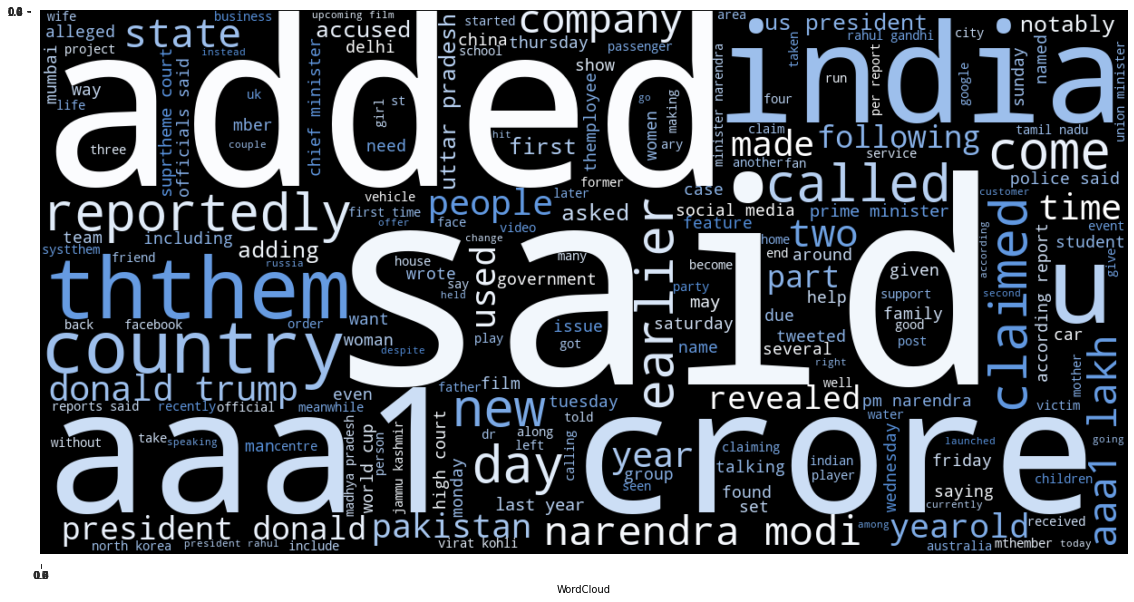

In [20]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [21]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

Again adding `tokens` ... but different ones.

In [22]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

It's important to use `sostok` and `eostok` as start and end tokens respectively as later while using `tensorflow's Tokenizer` will filter the tokens and covert them to lowercase.

**sostok** & **eostok** tokens are for us to know where to start & stop the summary because using `_START_` & `_END_`, tf's tokenizer with convert them to **start** & **end** respectively.

So while decoding the summary sequences of sentences like **'everything is going to end in 2012'** if use `_START_` & `_END_` tokens (which will make the sentence like **'start everything is going to end in 2012 end'** this) whome tf's tokenizer will convert to start and end then we will stop decoding as we hit first **end**, so this is bad and therefore **sostok** & **eostok** these tokens are used.

So we can just use these **sostok** & **eostok** instead of `_START_` & `_END_`, well you can but I tried both ways and while not using these `_START_` & `_END_` I was getting `undesired results` 🤯 😅 i.e. model's `results weren't good`.

In [23]:
df.sample(5)

,headlines,text
88989,sostok _START_ punjab police make second arres...,punjab police saturday arrested amritsar blast...
32928,sostok _START_ wanted publicity would posed pl...,gilu jo slutshamed breastfeeding baby cover ma...
55234,sostok _START_ feel small front soha ali khan ...,kareena kapoor speaking occasion sisterinlaw s...
60176,sostok _START_ want watch baahubali seeing tra...,actress sayani gupta said feel like watching f...
12371,sostok _START_ bharat special bagged role oppo...,actress disha patani seen salman khans bharat ...


Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


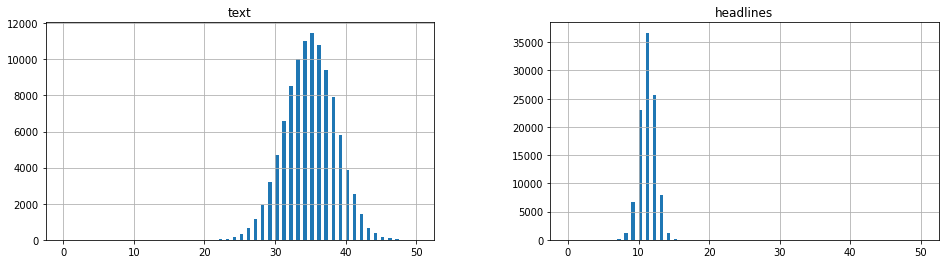

In [24]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [25]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.99
0.99


If the length of headlines or the text is kept large the deep learning model will face issues with performance and also training will slower.

One solution for creating summary for long sentences can be break a paragraph into sentences and then create a summary for them, this way the summary will make sence instead of giving random piece of text and creating summary for it.

In [26]:
max_text_len = 42
max_summary_len = 13

In [27]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 100258


,text,summary
87248,france imposed law requiring citizens display ...,sostok _START_ france require clean stickers c...
79580,indian fast bowler sreesanth revealed consider...,sostok _START_ play country sreesanth ban rest...
92636,ngo filed written complaint mumbai cyber polic...,sostok _START_ ngo files complaint rishi posti...
4937,late pm atal bihari vajpayees niece karuna shu...,sostok _START_ chhattisagrah cm nothing rajnan...
67151,union minister mukhtar abbas naqvi thursday sa...,sostok _START_ opposition stop banging head ev...


In [28]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

![](https://media.giphy.com/media/3o72EUwmrRFtyT1Vhm/giphy.gif)

In [29]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

**Tokenizing text 👉 x**

In [30]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.36, 'total_coverage': 2.95, 'count': 65213, 'total_count': 99775}


🔥 to `increase computation speed` use this

```python
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])
```

In [31]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [32]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

99776


**Tokenizing headlines(summary) 👉 y**

In [34]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 69.27, 'total_coverage': 4.81, 'count': 25994, 'total_count': 37523}


🔥 to `increase computation speed` use this

```python
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])
```

In [35]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [36]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

37524


In [38]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

## 🤼‍♂️ Modelling

![](https://media.giphy.com/media/YTJXDIivNMPuNSMgc0/giphy.gif)

In [39]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [40]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '../input/glove6b/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 55319 words (44456 misses)
Found 400000 word vectors.
Converted 27095 words (10428 misses)


In [41]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(99776, 300)
(37524, 300)


Using `pre-trained` embeddings and keeping the `Embedding` layer `non-trainable` we get increase in computation speed as don't need to compute the embedding matrix.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.

In [42]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

**Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

In [43]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)
        
        decoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.2,
                name='decoder_lstm_1'
            ),
            name='decoder_bidirectional_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_bi_lstm(
            decoder_embedding, initial_state=encoder_final_states
            # decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

**Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

In [44]:
def build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)
        
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.2,
            name='decoder_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [45]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 300)      29932800    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 240), (N 519360      embedding[0][0]                  
______________________________________________________________________________________________

If you want to change `model` then just change the `function name` above.

In [46]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [47]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [48]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

Use a `tuple` instead of `list` in `validation_parameter` in `model.fit()`, to know the reason reading this [post](https://stackoverflow.com/questions/61586981/valueerror-layer-sequential-20-expects-1-inputs-but-it-received-2-input-tensor).

In [49]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 37s 234ms/step - loss: 7.0099 - accuracy: 0.2499 - val_loss: 5.1364 - val_accuracy: 0.4292
Epoch 2/50
89/89 [==============================] - 5s 52ms/step - loss: 5.2058 - accuracy: 0.4184 - val_loss: 4.9203 - val_accuracy: 0.4332
Epoch 3/50
89/89 [==============================] - 5s 52ms/step - loss: 5.0199 - accuracy: 0.4224 - val_loss: 4.7193 - val_accuracy: 0.4374
Epoch 4/50
89/89 [==============================] - 5s 52ms/step - loss: 4.7725 - accuracy: 0.4284 - val_loss: 4.4864 - val_accuracy: 0.4452
Epoch 5/50
89/89 [==============================] - 5s 52ms/step - loss: 4.5356 - accuracy: 0.4364 - val_loss: 4.3093 - val_accuracy: 0.4525
Epoch 6/50
89/89 [==============================] - 5s 51ms/step - loss: 4.3404 - accuracy: 0.4430 - val_loss: 4.1756 - val_accuracy: 0.4585
Epoch 7/50
89/89 [==============================] - 5s 52ms/step - loss: 4.1772 - accuracy: 0.4489 - val_loss: 4.0440 - val_accuracy: 0.4642
Epoch 8/50


**Plotting model's performance**

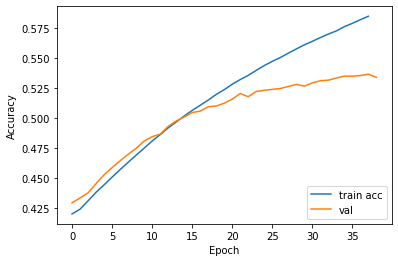

In [50]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

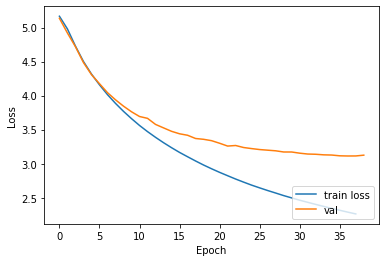

In [51]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## 🤸‍♂️ Inference

![](https://media.giphy.com/media/5FJcVeYFVysda/giphy.gif)

In [52]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [53]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

Useful `stackoverflow` [post](https://stackoverflow.com/questions/60697843/tensorflow-keras-bidirectional-lstm-for-text-summarization) to understand `inference` process when using `bidirectional lstms` in `encoder` and `decoder` in the training model.

In [54]:
def build_seq2seq_model_with_bidirectional_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get 
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [55]:
def build_hybrid_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get 
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        #decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [56]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [57]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 42, 300)           29932800  
_________________________________________________________________
lstm (LSTM)                  [(None, 42, 240), (None,  519360    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 42, 240), (None,  461760    
Total params: 30,913,920
Trainable params: 981,120
Non-trainable params: 29,932,800
_________________________________________________________________


In [58]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    11257200    input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 240)]        0                                            
____________________________________________________________________________________________

In [59]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

![](https://media.giphy.com/media/XKSa6XxpmHh1NEBvvl/giphy.gif)

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [60]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [61]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]
        
        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [62]:
def decode_sequence_hybrid_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values[:2]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]
        
        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [63]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [64]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [65]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


For predicting `unseen` data pass `decode_sequence` function for which you want to decode.

In [66]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

## 🔮 Predictions

![](https://media.giphy.com/media/1wqqlaQ7IX3TXibXZE/giphy.gif)

In [67]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  spanish fashion retailer zara withdrawn skirt website facing criticism featuring pepe frog internet mtheme turned symbol white nationalist altright movthement zara seriously wallet shopping elsewhere commented user hmm pepe zara skirt wtf read another comment 
Original summary:  start zara withdraws skirt featuring pepe frog altright mtheme end 
Predicted summary:   start zara slammed racist ad ad featuring pepe end

# 2 News:  elections fill vacant seats rajya sabha held today mthembers elected unopposed one seats facing byelections kerala mp resigned mber mthembers uttar pradesh maharashtra bihar six mthembers gujarat four 
Original summary:  start explained details rajya sabha election held today end 
Predicted summary:   start rajya sabha seats ls polls may get majority end

# 3 News:  first posthumous nobel prize awarded swedens erik karlfeldt literature posthumous nobel peace prize given youngest united nations secretarygeneral dag hamkjaald economist william vickrey d

In [68]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  italian space agency scientists expressed interest developing robotic technology bring asteroid beyond lunar orbit back closer reach order better study mission could also help planetary defence deflect potentially hazardous asteroid might impact earth notably nasa looking robotics development asteroid redirect mission 
Original summary:  start scientists propose bringing asteroid closer earth end 
Predicted summary:   start nasa planning spacecraft saturn moon mission mercury end

# 2 News:  palestinian president mahmoud abbas said social behaviour jews responsible holocaust addressing meeting ramallah monday abbas claimed jews faced persecution europe due social behaviour related banking israeli prime minister benjamin netanyahu slammed abbas accusing antisthemitism 
Original summary:  start jews social behaviour led holocaust palestine president end 
Predicted summary:   start israel calls jerusalthem jews jews jews prez end

# 3 News:  batsman hanuma vihari become first a

## 🎁 Saving the model

In [69]:
# HDF5 format
model.save('model.h5')    
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

## 🏌️‍♂️ Running all the 3 different models

After understanding how all the pieces work, running all the `3 models` to understand how it `performs` and its `results`.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

![](https://media.giphy.com/media/3ogmaPGsQOruw/giphy.gif)

In [70]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    },
    'hybrid_model': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

**Model with just LSTMs**

In [71]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [72]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 300)      29932800    input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 42, 240), (N 519360      embedding_2[0][0]                
____________________________________________________________________________________________

In [73]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 37s 227ms/step - loss: 7.0021 - accuracy: 0.2465 - val_loss: 5.1189 - val_accuracy: 0.4284
Epoch 2/50
89/89 [==============================] - 5s 51ms/step - loss: 5.2113 - accuracy: 0.4181 - val_loss: 4.9496 - val_accuracy: 0.4316
Epoch 3/50
89/89 [==============================] - 5s 51ms/step - loss: 5.0362 - accuracy: 0.4231 - val_loss: 4.7615 - val_accuracy: 0.4370
Epoch 4/50
89/89 [==============================] - 5s 51ms/step - loss: 4.8063 - accuracy: 0.4281 - val_loss: 4.5179 - val_accuracy: 0.4447
Epoch 5/50
89/89 [==============================] - 5s 51ms/step - loss: 4.5459 - accuracy: 0.4360 - val_loss: 4.3064 - val_accuracy: 0.4520
Epoch 6/50
89/89 [==============================] - 5s 52ms/step - loss: 4.3302 - accuracy: 0.4434 - val_loss: 4.1767 - val_accuracy: 0.4577
Epoch 7/50
89/89 [==============================] - 5s 52ms/step - loss: 4.1516 - accuracy: 0.4506 - val_loss: 4.0780 - val_accuracy: 0.4600
Epoch 8/50


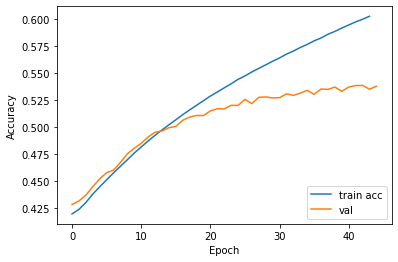

In [74]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

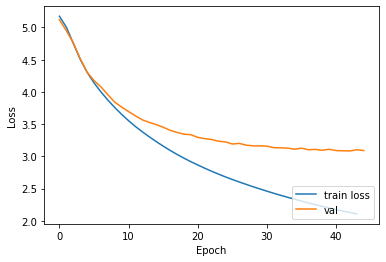

In [75]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [76]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [77]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 42, 300)           29932800  
_________________________________________________________________
lstm_3 (LSTM)                [(None, 42, 240), (None,  519360    
_________________________________________________________________
lstm_4 (LSTM)                [(None, 42, 240), (None,  461760    
Total params: 30,913,920
Trainable params: 981,120
Non-trainable params: 29,932,800
_________________________________________________________________


In [78]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 300)    11257200    input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 240)]        0                                            
____________________________________________________________________________________________

In [79]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  spanish fashion retailer zara withdrawn skirt website facing criticism featuring pepe frog internet mtheme turned symbol white nationalist altright movthement zara seriously wallet shopping elsewhere commented user hmm pepe zara skirt wtf read another comment 
Original summary:  start zara withdraws skirt featuring pepe frog altright mtheme end 
Predicted summary:   start zara launches ad featuring pepe frog altright dress end

# 2 News:  elections fill vacant seats rajya sabha held today mthembers elected unopposed one seats facing byelections kerala mp resigned mber mthembers uttar pradesh maharashtra bihar six mthembers gujarat four 
Original summary:  start explained details rajya sabha election held today end 
Predicted summary:   start rajya sabha seats rajya sabha seats end

# 3 News:  first posthumous nobel prize awarded swedens erik karlfeldt literature posthumous nobel peace prize given youngest united nations secretarygeneral dag hamkjaald economist william vickre

**Model with Bidirectional LSTMs**

In [80]:
model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [81]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 42, 300)      29932800    input_11[0][0]                   
__________________________________________________________________________________________________
encoder_bidirectional_lstm_1 (B [(None, 42, 480), (N 1038720     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________

In [82]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 61s 334ms/step - loss: 6.4102 - accuracy: 0.3250 - val_loss: 4.3666 - val_accuracy: 0.4567
Epoch 2/50
89/89 [==============================] - 7s 83ms/step - loss: 4.2414 - accuracy: 0.4610 - val_loss: 3.2875 - val_accuracy: 0.5459
Epoch 3/50
89/89 [==============================] - 7s 82ms/step - loss: 3.2620 - accuracy: 0.5488 - val_loss: 2.4934 - val_accuracy: 0.6362
Epoch 4/50
89/89 [==============================] - 7s 82ms/step - loss: 2.5241 - accuracy: 0.6396 - val_loss: 1.9252 - val_accuracy: 0.7176
Epoch 5/50
89/89 [==============================] - 7s 83ms/step - loss: 1.9854 - accuracy: 0.7159 - val_loss: 1.5201 - val_accuracy: 0.7789
Epoch 6/50
89/89 [==============================] - 7s 84ms/step - loss: 1.5887 - accuracy: 0.7749 - val_loss: 1.2316 - val_accuracy: 0.8263
Epoch 7/50
89/89 [==============================] - 7s 83ms/step - loss: 1.2919 - accuracy: 0.8190 - val_loss: 1.0260 - val_accuracy: 0.8556
Epoch 8/50


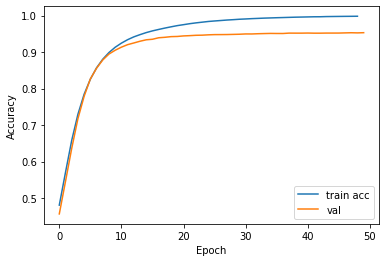

In [83]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

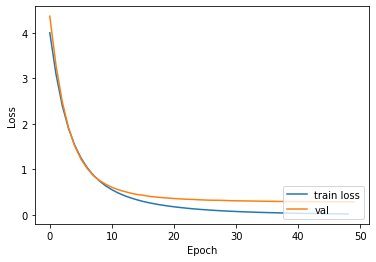

In [84]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [85]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [86]:
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
encoder_embedding (Embedding (None, 42, 300)           29932800  
_________________________________________________________________
encoder_bidirectional_lstm_1 [(None, 42, 480), (None,  1038720   
_________________________________________________________________
encoder_bidirectional_lstm_2 [(None, 42, 480), (None,  1384320   
_________________________________________________________________
encoder_bidirectional_lstm_3 [(None, 42, 480), (None,  1384320   
Total params: 33,740,160
Trainable params: 3,807,360
Non-trainable params: 29,932,800
_________________________________________________________________


In [87]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 300)    11257200    input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 240)]        0                                            
____________________________________________________________________________________________

In [88]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  spanish fashion retailer zara withdrawn skirt website facing criticism featuring pepe frog internet mtheme turned symbol white nationalist altright movthement zara seriously wallet shopping elsewhere commented user hmm pepe zara skirt wtf read another comment 
Original summary:  start zara withdraws skirt featuring pepe frog altright mtheme end 
Predicted summary:   end end end end end end end end end end end end

# 2 News:  elections fill vacant seats rajya sabha held today mthembers elected unopposed one seats facing byelections kerala mp resigned mber mthembers uttar pradesh maharashtra bihar six mthembers gujarat four 
Original summary:  start explained details rajya sabha election held today end 
Predicted summary:   end end end end end end end end end end end end

# 3 News:  first posthumous nobel prize awarded swedens erik karlfeldt literature posthumous nobel peace prize given youngest united nations secretarygeneral dag hamkjaald economist william vickrey died prese

### Model with hybrid architecture

In [89]:
model_func = models_info['hybrid_model']['model']
inference_func = models_info['hybrid_model']['inference']
decode_sequence_func = models_info['hybrid_model']['decode_sequence']

In [90]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 42, 300)      29932800    input_18[0][0]                   
__________________________________________________________________________________________________
encoder_bidirectional_lstm_1 (B [(None, 42, 480), (N 1038720     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________

In [91]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 49s 270ms/step - loss: 7.0281 - accuracy: 0.2449 - val_loss: 5.1333 - val_accuracy: 0.4277
Epoch 2/50
89/89 [==============================] - 6s 71ms/step - loss: 5.2092 - accuracy: 0.4184 - val_loss: 4.9388 - val_accuracy: 0.4325
Epoch 3/50
89/89 [==============================] - 6s 71ms/step - loss: 5.0413 - accuracy: 0.4215 - val_loss: 4.7435 - val_accuracy: 0.4359
Epoch 4/50
89/89 [==============================] - 6s 72ms/step - loss: 4.7893 - accuracy: 0.4276 - val_loss: 4.5190 - val_accuracy: 0.4422
Epoch 5/50
89/89 [==============================] - 6s 72ms/step - loss: 4.5488 - accuracy: 0.4336 - val_loss: 4.3426 - val_accuracy: 0.4483
Epoch 6/50
89/89 [==============================] - 6s 72ms/step - loss: 4.3701 - accuracy: 0.4389 - val_loss: 4.2001 - val_accuracy: 0.4542
Epoch 7/50
89/89 [==============================] - 6s 72ms/step - loss: 4.2124 - accuracy: 0.4449 - val_loss: 4.0844 - val_accuracy: 0.4589
Epoch 8/50


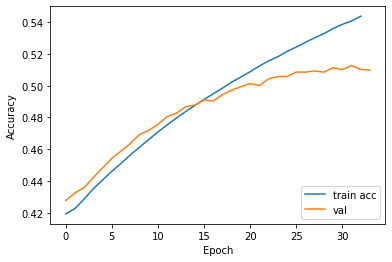

In [92]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

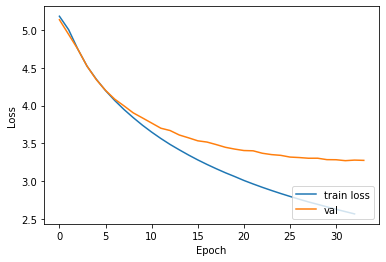

In [93]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [94]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [95]:
encoder_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
encoder_embedding (Embedding (None, 42, 300)           29932800  
_________________________________________________________________
encoder_bidirectional_lstm_1 [(None, 42, 480), (None,  1038720   
_________________________________________________________________
encoder_bidirectional_lstm_2 [(None, 42, 480), (None,  1384320   
_________________________________________________________________
encoder_bidirectional_lstm_3 [(None, 42, 480), (None,  1384320   
Total params: 33,740,160
Trainable params: 3,807,360
Non-trainable params: 29,932,800
_________________________________________________________________


In [96]:
decoder_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 300)    11257200    input_19[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 240)]        0                                            
____________________________________________________________________________________________

In [97]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  spanish fashion retailer zara withdrawn skirt website facing criticism featuring pepe frog internet mtheme turned symbol white nationalist altright movthement zara seriously wallet shopping elsewhere commented user hmm pepe zara skirt wtf read another comment 
Original summary:  start zara withdraws skirt featuring pepe frog altright mtheme end 
Predicted summary:   sostok abvp instagram dthemocracy filed filed filed volcano start india end end

# 2 News:  elections fill vacant seats rajya sabha held today mthembers elected unopposed one seats facing byelections kerala mp resigned mber mthembers uttar pradesh maharashtra bihar six mthembers gujarat four 
Original summary:  start explained details rajya sabha election held today end 
Predicted summary:   sostok fm ied using lawyer lawyer lawyer birth start india end end

# 3 News:  first posthumous nobel prize awarded swedens erik karlfeldt literature posthumous nobel peace prize given youngest united nations secretarygeneral

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/3o85xAYQLOhSrmINHO/giphy.gif)

---